In [4]:
%pip install -e ..

Obtaining file:///Users/sethvanderbijl/Coding%20Projects/DM_project_2
  Attempting uninstall: DM-project-2
    Found existing installation: DM-project-2 1.0
    Uninstalling DM-project-2-1.0:
      Successfully uninstalled DM-project-2-1.0
  Running setup.py develop for DM-project-2
You should consider upgrading via the '/Users/sethvanderbijl/Coding Projects/DM_project_2/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from data.load import load_data
from model import RegressionDataset, MultipleRegression
import os

/Users/sethvanderbijl/Coding Projects/DM_project_2/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load data
df = load_data(num_rows=100000)
test = load_data(mode='our_test', num_rows=100000)

No cache for this specific request, start loading base df from disk.
saving result of specific arguments to cache


100%|██████████| 500/500 [00:14<00:00, 34.12it/s]


No cache for this specific request, start loading base df from disk.
saving result of specific arguments to cache


100%|██████████| 500/500 [00:01<00:00, 278.30it/s]


In [5]:
# RM redundant features and fill NA
y = df['booking_bool']
X = df.drop(['booking_bool','click_bool', 'position', 'gross_bookings_usd', 'date_time'], axis=1)
X = X.fillna(X.mean())

X_train, y_train = X, y
X_test = test.drop(['booking_bool','click_bool', 'position', 'gross_bookings_usd', 'date_time'], axis=1)
X_test = X_test.fillna(X.mean()) #Mean of x or mean of x_test?


# Split for val data
y_test = test['booking_bool']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)

In [6]:
# Normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:
# Convert to float
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [11]:
# Set the params
EPOCHS = 300
BATCH_SIZE = 32
LEARNING_RATE = 0.008
NUM_FEATURES = X.shape[1]

# Save destination
prefix = os.path.abspath('')
best_model_path = prefix+"/saves/best_new"+".pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Initialize datasets as dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [13]:
# Initialize that model!
model = MultipleRegression(NUM_FEATURES)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr=LEARNING_RATE)

In [14]:
# Keep track of training progress in dict
loss_stats = {
    'train': [],
    "val": []
}

# Save last validation loss to save best model
last_val_loss = 9999999999

# Let the training beginn
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
        print("\r", f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}', end="")

        # Save the model if val loss is better
        if val_epoch_loss/len(val_loader)< last_val_loss:
            last_val_loss = val_epoch_loss/len(val_loader)
            torch.save(model.state_dict(), best_model_path)

  0%|          | 1/300 [00:09<46:38,  9.36s/it]

Epoch 001: | Train Loss: 0.02756 | Val Loss: 0.02909


  1%|          | 2/300 [00:18<46:47,  9.42s/it]

Epoch 002: | Train Loss: 0.02752 | Val Loss: 0.02909


  1%|          | 3/300 [00:28<46:14,  9.34s/it]

Epoch 003: | Train Loss: 0.02752 | Val Loss: 0.02909


  1%|▏         | 4/300 [00:37<45:26,  9.21s/it]

Epoch 004: | Train Loss: 0.02752 | Val Loss: 0.02909


  2%|▏         | 5/300 [00:47<47:55,  9.75s/it]

Epoch 005: | Train Loss: 0.02753 | Val Loss: 0.02909


  2%|▏         | 6/300 [00:56<46:35,  9.51s/it]

Epoch 006: | Train Loss: 0.02753 | Val Loss: 0.02909


  2%|▏         | 7/300 [01:07<48:55, 10.02s/it]

Epoch 007: | Train Loss: 0.02752 | Val Loss: 0.02909


  3%|▎         | 8/300 [01:19<50:28, 10.37s/it]

Epoch 008: | Train Loss: 0.02752 | Val Loss: 0.02909


  3%|▎         | 9/300 [01:28<48:21,  9.97s/it]

Epoch 009: | Train Loss: 0.02753 | Val Loss: 0.02909


  3%|▎         | 10/300 [01:37<46:49,  9.69s/it]

Epoch 010: | Train Loss: 0.02752 | Val Loss: 0.02909


  4%|▎         | 11/300 [01:46<45:49,  9.51s/it]

Epoch 011: | Train Loss: 0.02752 | Val Loss: 0.02909


  4%|▍         | 12/300 [01:56<47:18,  9.85s/it]

Epoch 012: | Train Loss: 0.02752 | Val Loss: 0.02909


  4%|▍         | 13/300 [02:06<46:56,  9.81s/it]

Epoch 013: | Train Loss: 0.02752 | Val Loss: 0.02909


  5%|▍         | 14/300 [02:16<46:40,  9.79s/it]

Epoch 014: | Train Loss: 0.02752 | Val Loss: 0.02909


  5%|▌         | 15/300 [02:25<45:54,  9.66s/it]

Epoch 015: | Train Loss: 0.02752 | Val Loss: 0.02909


  5%|▌         | 16/300 [02:35<46:00,  9.72s/it]

Epoch 016: | Train Loss: 0.02753 | Val Loss: 0.02909


  6%|▌         | 17/300 [02:44<44:24,  9.41s/it]

Epoch 017: | Train Loss: 0.02752 | Val Loss: 0.02909


  6%|▌         | 18/300 [02:53<43:24,  9.24s/it]

Epoch 018: | Train Loss: 0.02752 | Val Loss: 0.02909


  6%|▋         | 19/300 [03:01<42:43,  9.12s/it]

Epoch 019: | Train Loss: 0.02752 | Val Loss: 0.02909


  7%|▋         | 20/300 [03:10<41:59,  9.00s/it]

Epoch 020: | Train Loss: 0.02752 | Val Loss: 0.02909


  7%|▋         | 21/300 [03:19<41:43,  8.97s/it]

Epoch 021: | Train Loss: 0.02752 | Val Loss: 0.02909


  7%|▋         | 22/300 [03:28<40:59,  8.85s/it]

Epoch 022: | Train Loss: 0.02752 | Val Loss: 0.02909


  8%|▊         | 23/300 [03:37<41:08,  8.91s/it]

Epoch 023: | Train Loss: 0.02752 | Val Loss: 0.02909


  8%|▊         | 24/300 [03:46<40:50,  8.88s/it]

Epoch 024: | Train Loss: 0.02752 | Val Loss: 0.02909


  8%|▊         | 25/300 [03:54<40:40,  8.87s/it]

Epoch 025: | Train Loss: 0.02752 | Val Loss: 0.02909


  9%|▊         | 26/300 [04:03<39:58,  8.76s/it]

Epoch 026: | Train Loss: 0.02752 | Val Loss: 0.02909


  9%|▉         | 27/300 [04:11<39:20,  8.65s/it]

Epoch 027: | Train Loss: 0.02752 | Val Loss: 0.02909


  9%|▉         | 28/300 [04:22<41:44,  9.21s/it]

Epoch 028: | Train Loss: 0.02752 | Val Loss: 0.02909


 10%|▉         | 29/300 [04:33<44:05,  9.76s/it]

Epoch 029: | Train Loss: 0.02752 | Val Loss: 0.02909


 10%|█         | 30/300 [04:45<47:14, 10.50s/it]

Epoch 030: | Train Loss: 0.02752 | Val Loss: 0.02909


 10%|█         | 31/300 [04:55<46:29, 10.37s/it]

Epoch 031: | Train Loss: 0.02752 | Val Loss: 0.02909


 11%|█         | 32/300 [05:06<46:27, 10.40s/it]

Epoch 032: | Train Loss: 0.02752 | Val Loss: 0.02909


 11%|█         | 33/300 [05:18<48:28, 10.89s/it]

Epoch 033: | Train Loss: 0.02752 | Val Loss: 0.02909


 11%|█▏        | 34/300 [05:28<47:47, 10.78s/it]

Epoch 034: | Train Loss: 0.02752 | Val Loss: 0.02909


 12%|█▏        | 35/300 [05:39<47:23, 10.73s/it]

Epoch 035: | Train Loss: 0.02752 | Val Loss: 0.02909


 12%|█▏        | 36/300 [05:49<46:53, 10.66s/it]

Epoch 036: | Train Loss: 0.02753 | Val Loss: 0.02909


 12%|█▏        | 37/300 [05:59<45:16, 10.33s/it]

Epoch 037: | Train Loss: 0.02752 | Val Loss: 0.02909


 13%|█▎        | 38/300 [06:09<44:36, 10.22s/it]

Epoch 038: | Train Loss: 0.02752 | Val Loss: 0.02909


 13%|█▎        | 39/300 [06:19<43:57, 10.11s/it]

Epoch 039: | Train Loss: 0.02752 | Val Loss: 0.02909


 13%|█▎        | 40/300 [06:29<44:00, 10.16s/it]

Epoch 040: | Train Loss: 0.02752 | Val Loss: 0.02909


 14%|█▎        | 41/300 [06:38<42:30,  9.85s/it]

Epoch 041: | Train Loss: 0.02752 | Val Loss: 0.02909


 14%|█▍        | 42/300 [06:47<41:25,  9.63s/it]

Epoch 042: | Train Loss: 0.02754 | Val Loss: 0.02909


 14%|█▍        | 43/300 [06:56<39:56,  9.33s/it]

Epoch 043: | Train Loss: 0.02752 | Val Loss: 0.02909


 15%|█▍        | 44/300 [07:04<38:56,  9.13s/it]

Epoch 044: | Train Loss: 0.02752 | Val Loss: 0.02909


 15%|█▌        | 45/300 [07:13<38:03,  8.95s/it]

Epoch 045: | Train Loss: 0.02752 | Val Loss: 0.02909


 15%|█▌        | 46/300 [07:22<38:07,  9.01s/it]

Epoch 046: | Train Loss: 0.02752 | Val Loss: 0.02909


 16%|█▌        | 47/300 [07:35<43:17, 10.27s/it]

Epoch 047: | Train Loss: 0.02752 | Val Loss: 0.02909


 16%|█▌        | 48/300 [07:45<42:15, 10.06s/it]

Epoch 048: | Train Loss: 0.02752 | Val Loss: 0.02909


 16%|█▋        | 49/300 [07:55<42:02, 10.05s/it]

Epoch 049: | Train Loss: 0.02752 | Val Loss: 0.02909


 17%|█▋        | 50/300 [08:07<43:50, 10.52s/it]

Epoch 050: | Train Loss: 0.02752 | Val Loss: 0.02909


 17%|█▋        | 51/300 [08:16<42:49, 10.32s/it]

Epoch 051: | Train Loss: 0.02752 | Val Loss: 0.02909


 17%|█▋        | 52/300 [08:26<42:10, 10.20s/it]

Epoch 052: | Train Loss: 0.02752 | Val Loss: 0.02909


 18%|█▊        | 53/300 [08:37<42:56, 10.43s/it]

Epoch 053: | Train Loss: 0.02752 | Val Loss: 0.02909


 18%|█▊        | 54/300 [08:48<43:03, 10.50s/it]

Epoch 054: | Train Loss: 0.02752 | Val Loss: 0.02909


 18%|█▊        | 55/300 [09:00<44:24, 10.87s/it]

Epoch 055: | Train Loss: 0.02752 | Val Loss: 0.02909


 19%|█▊        | 56/300 [09:10<43:27, 10.69s/it]

Epoch 056: | Train Loss: 0.02752 | Val Loss: 0.02909


 19%|█▉        | 57/300 [09:28<52:13, 12.90s/it]

Epoch 057: | Train Loss: 0.02752 | Val Loss: 0.02909


 19%|█▉        | 58/300 [09:47<59:30, 14.76s/it]

Epoch 058: | Train Loss: 0.02752 | Val Loss: 0.02909


 20%|█▉        | 59/300 [10:02<59:13, 14.74s/it]

Epoch 059: | Train Loss: 0.02752 | Val Loss: 0.02909


 20%|██        | 60/300 [10:13<54:33, 13.64s/it]

Epoch 060: | Train Loss: 0.02752 | Val Loss: 0.02909


 20%|██        | 61/300 [10:22<48:35, 12.20s/it]

Epoch 061: | Train Loss: 0.02752 | Val Loss: 0.02909


 21%|██        | 62/300 [10:31<44:40, 11.26s/it]

Epoch 062: | Train Loss: 0.02752 | Val Loss: 0.02909


 21%|██        | 63/300 [10:40<41:36, 10.53s/it]

Epoch 063: | Train Loss: 0.02752 | Val Loss: 0.02909


 21%|██▏       | 64/300 [10:49<39:43, 10.10s/it]

Epoch 064: | Train Loss: 0.02752 | Val Loss: 0.02909


 22%|██▏       | 65/300 [10:57<37:48,  9.65s/it]

Epoch 065: | Train Loss: 0.02752 | Val Loss: 0.02909


 22%|██▏       | 66/300 [11:07<37:57,  9.73s/it]

Epoch 066: | Train Loss: 0.02753 | Val Loss: 0.02909


 22%|██▏       | 67/300 [11:18<38:46,  9.98s/it]

Epoch 067: | Train Loss: 0.02752 | Val Loss: 0.02909


 23%|██▎       | 68/300 [11:28<39:15, 10.15s/it]

Epoch 068: | Train Loss: 0.02752 | Val Loss: 0.02909


 23%|██▎       | 69/300 [11:40<40:18, 10.47s/it]

Epoch 069: | Train Loss: 0.02752 | Val Loss: 0.02909


 23%|██▎       | 70/300 [11:51<41:07, 10.73s/it]

Epoch 070: | Train Loss: 0.02752 | Val Loss: 0.02909


 24%|██▎       | 71/300 [12:01<40:14, 10.54s/it]

Epoch 071: | Train Loss: 0.02752 | Val Loss: 0.02909


 24%|██▍       | 72/300 [12:10<38:36, 10.16s/it]

Epoch 072: | Train Loss: 0.02752 | Val Loss: 0.02909


 24%|██▍       | 73/300 [12:21<38:41, 10.23s/it]

Epoch 073: | Train Loss: 0.02752 | Val Loss: 0.02909


 25%|██▍       | 74/300 [12:30<37:04,  9.84s/it]

Epoch 074: | Train Loss: 0.02752 | Val Loss: 0.02909


 25%|██▌       | 75/300 [12:40<37:15,  9.94s/it]

Epoch 075: | Train Loss: 0.02752 | Val Loss: 0.02909


 25%|██▌       | 76/300 [12:53<41:01, 10.99s/it]

Epoch 076: | Train Loss: 0.02752 | Val Loss: 0.02909


 26%|██▌       | 77/300 [13:03<39:50, 10.72s/it]

Epoch 077: | Train Loss: 0.02752 | Val Loss: 0.02909


 26%|██▌       | 78/300 [13:12<37:56, 10.25s/it]

Epoch 078: | Train Loss: 0.02752 | Val Loss: 0.02909


 26%|██▋       | 79/300 [13:21<36:17,  9.85s/it]

Epoch 079: | Train Loss: 0.02752 | Val Loss: 0.02909


 27%|██▋       | 80/300 [13:30<34:49,  9.50s/it]

Epoch 080: | Train Loss: 0.02752 | Val Loss: 0.02909


 27%|██▋       | 81/300 [13:40<35:23,  9.70s/it]

Epoch 081: | Train Loss: 0.02752 | Val Loss: 0.02909


 27%|██▋       | 82/300 [13:51<35:58,  9.90s/it]

Epoch 082: | Train Loss: 0.02752 | Val Loss: 0.02909


 28%|██▊       | 83/300 [14:01<36:47, 10.17s/it]

Epoch 083: | Train Loss: 0.02752 | Val Loss: 0.02909


 28%|██▊       | 84/300 [14:13<37:40, 10.47s/it]

Epoch 084: | Train Loss: 0.02752 | Val Loss: 0.02909


 28%|██▊       | 85/300 [14:22<36:20, 10.14s/it]

Epoch 085: | Train Loss: 0.02752 | Val Loss: 0.02909


 29%|██▊       | 86/300 [14:31<35:07,  9.85s/it]

Epoch 086: | Train Loss: 0.02752 | Val Loss: 0.02909


 29%|██▉       | 87/300 [14:41<35:17,  9.94s/it]

Epoch 087: | Train Loss: 0.02752 | Val Loss: 0.02909


 29%|██▉       | 88/300 [14:51<35:27, 10.03s/it]

Epoch 088: | Train Loss: 0.02753 | Val Loss: 0.02909


 30%|██▉       | 89/300 [15:02<36:01, 10.24s/it]

Epoch 089: | Train Loss: 0.02752 | Val Loss: 0.02909


 30%|███       | 90/300 [15:14<37:13, 10.64s/it]

Epoch 090: | Train Loss: 0.02752 | Val Loss: 0.02909


 30%|███       | 91/300 [15:24<36:36, 10.51s/it]

Epoch 091: | Train Loss: 0.02752 | Val Loss: 0.02909


 31%|███       | 92/300 [15:33<34:51, 10.06s/it]

Epoch 092: | Train Loss: 0.02752 | Val Loss: 0.02909


 31%|███       | 93/300 [15:42<33:54,  9.83s/it]

Epoch 093: | Train Loss: 0.02752 | Val Loss: 0.02909


 31%|███▏      | 94/300 [15:51<33:03,  9.63s/it]

Epoch 094: | Train Loss: 0.02752 | Val Loss: 0.02909


 32%|███▏      | 95/300 [16:00<32:10,  9.42s/it]

Epoch 095: | Train Loss: 0.02752 | Val Loss: 0.02909


 32%|███▏      | 96/300 [16:10<31:49,  9.36s/it]

Epoch 096: | Train Loss: 0.02752 | Val Loss: 0.02909


 32%|███▏      | 97/300 [16:20<32:17,  9.54s/it]

Epoch 097: | Train Loss: 0.02752 | Val Loss: 0.02909


 33%|███▎      | 98/300 [16:30<33:13,  9.87s/it]

Epoch 098: | Train Loss: 0.02752 | Val Loss: 0.02909


 33%|███▎      | 99/300 [16:39<32:18,  9.64s/it]

Epoch 099: | Train Loss: 0.02752 | Val Loss: 0.02909


 33%|███▎      | 100/300 [16:49<32:31,  9.76s/it]

Epoch 100: | Train Loss: 0.02752 | Val Loss: 0.02909


 34%|███▎      | 101/300 [17:00<32:48,  9.89s/it]

Epoch 101: | Train Loss: 0.02752 | Val Loss: 0.02909


 34%|███▍      | 102/300 [17:09<31:44,  9.62s/it]

Epoch 102: | Train Loss: 0.02753 | Val Loss: 0.02909


 34%|███▍      | 103/300 [17:18<31:11,  9.50s/it]

Epoch 103: | Train Loss: 0.02752 | Val Loss: 0.02909


 35%|███▍      | 104/300 [17:27<30:25,  9.31s/it]

Epoch 104: | Train Loss: 0.02752 | Val Loss: 0.02909


 35%|███▌      | 105/300 [17:36<30:07,  9.27s/it]

Epoch 105: | Train Loss: 0.02753 | Val Loss: 0.02909


 35%|███▌      | 106/300 [17:49<34:01, 10.52s/it]

Epoch 106: | Train Loss: 0.02752 | Val Loss: 0.02909


 36%|███▌      | 107/300 [18:00<34:33, 10.74s/it]

Epoch 107: | Train Loss: 0.02752 | Val Loss: 0.02909


 36%|███▌      | 108/300 [18:10<33:36, 10.50s/it]

Epoch 108: | Train Loss: 0.02752 | Val Loss: 0.02909


 36%|███▋      | 109/300 [18:21<33:10, 10.42s/it]

Epoch 109: | Train Loss: 0.02752 | Val Loss: 0.02909


 37%|███▋      | 110/300 [18:30<32:14, 10.18s/it]

Epoch 110: | Train Loss: 0.02752 | Val Loss: 0.02909


 37%|███▋      | 111/300 [18:40<31:49, 10.10s/it]

Epoch 111: | Train Loss: 0.02752 | Val Loss: 0.02909


 37%|███▋      | 112/300 [18:50<31:49, 10.16s/it]

Epoch 112: | Train Loss: 0.02752 | Val Loss: 0.02909


 38%|███▊      | 113/300 [19:00<31:06,  9.98s/it]

Epoch 113: | Train Loss: 0.02753 | Val Loss: 0.02909


 38%|███▊      | 114/300 [19:10<30:48,  9.94s/it]

Epoch 114: | Train Loss: 0.02752 | Val Loss: 0.02909


 38%|███▊      | 115/300 [19:21<31:20, 10.17s/it]

Epoch 115: | Train Loss: 0.02752 | Val Loss: 0.02909


 39%|███▊      | 116/300 [19:32<32:36, 10.63s/it]

Epoch 116: | Train Loss: 0.02753 | Val Loss: 0.02909


 39%|███▉      | 117/300 [19:43<32:25, 10.63s/it]

Epoch 117: | Train Loss: 0.02752 | Val Loss: 0.02909


 39%|███▉      | 118/300 [19:52<31:04, 10.25s/it]

Epoch 118: | Train Loss: 0.02752 | Val Loss: 0.02909


 40%|███▉      | 119/300 [20:02<30:10, 10.00s/it]

Epoch 119: | Train Loss: 0.02752 | Val Loss: 0.02909


 40%|████      | 120/300 [20:12<30:26, 10.15s/it]

Epoch 120: | Train Loss: 0.02752 | Val Loss: 0.02909


 40%|████      | 121/300 [20:22<30:16, 10.15s/it]

Epoch 121: | Train Loss: 0.02752 | Val Loss: 0.02909


 41%|████      | 122/300 [20:35<32:18, 10.89s/it]

Epoch 122: | Train Loss: 0.02752 | Val Loss: 0.02909


 41%|████      | 123/300 [20:48<34:04, 11.55s/it]

Epoch 123: | Train Loss: 0.02752 | Val Loss: 0.02909


 41%|████▏     | 124/300 [21:01<35:00, 11.94s/it]

Epoch 124: | Train Loss: 0.02752 | Val Loss: 0.02909


 42%|████▏     | 125/300 [21:13<34:59, 12.00s/it]

Epoch 125: | Train Loss: 0.02752 | Val Loss: 0.02909


 42%|████▏     | 126/300 [21:25<34:57, 12.05s/it]

Epoch 126: | Train Loss: 0.02752 | Val Loss: 0.02909


 42%|████▏     | 127/300 [21:35<32:40, 11.33s/it]

Epoch 127: | Train Loss: 0.02752 | Val Loss: 0.02909


 43%|████▎     | 128/300 [21:45<31:19, 10.93s/it]

Epoch 128: | Train Loss: 0.02752 | Val Loss: 0.02909


 43%|████▎     | 129/300 [21:55<30:25, 10.67s/it]

Epoch 129: | Train Loss: 0.02753 | Val Loss: 0.02909


 43%|████▎     | 130/300 [22:05<29:24, 10.38s/it]

Epoch 130: | Train Loss: 0.02752 | Val Loss: 0.02909


 44%|████▎     | 131/300 [22:15<29:00, 10.30s/it]

Epoch 131: | Train Loss: 0.02752 | Val Loss: 0.02909


 44%|████▍     | 132/300 [22:24<28:00, 10.00s/it]

Epoch 132: | Train Loss: 0.02752 | Val Loss: 0.02909


 44%|████▍     | 133/300 [22:33<26:43,  9.60s/it]

Epoch 133: | Train Loss: 0.02753 | Val Loss: 0.02909


 45%|████▍     | 134/300 [22:41<25:46,  9.32s/it]

Epoch 134: | Train Loss: 0.02752 | Val Loss: 0.02909


 45%|████▌     | 135/300 [22:50<25:04,  9.12s/it]

Epoch 135: | Train Loss: 0.02752 | Val Loss: 0.02909


 45%|████▌     | 136/300 [22:59<24:38,  9.02s/it]

Epoch 136: | Train Loss: 0.02752 | Val Loss: 0.02909


 46%|████▌     | 137/300 [23:07<24:02,  8.85s/it]

Epoch 137: | Train Loss: 0.02752 | Val Loss: 0.02909


 46%|████▌     | 138/300 [23:17<24:44,  9.17s/it]

Epoch 138: | Train Loss: 0.02752 | Val Loss: 0.02909


 46%|████▋     | 139/300 [23:27<24:56,  9.29s/it]

Epoch 139: | Train Loss: 0.02752 | Val Loss: 0.02909


 47%|████▋     | 140/300 [23:36<24:54,  9.34s/it]

Epoch 140: | Train Loss: 0.02752 | Val Loss: 0.02909


 47%|████▋     | 141/300 [23:47<25:48,  9.74s/it]

Epoch 141: | Train Loss: 0.02752 | Val Loss: 0.02909


 47%|████▋     | 142/300 [23:57<25:51,  9.82s/it]

Epoch 142: | Train Loss: 0.02752 | Val Loss: 0.02909


 48%|████▊     | 143/300 [24:06<25:05,  9.59s/it]

Epoch 143: | Train Loss: 0.02752 | Val Loss: 0.02909


 48%|████▊     | 144/300 [24:16<24:56,  9.59s/it]

Epoch 144: | Train Loss: 0.02752 | Val Loss: 0.02909


 48%|████▊     | 145/300 [24:26<25:10,  9.75s/it]

Epoch 145: | Train Loss: 0.02753 | Val Loss: 0.02909


 49%|████▊     | 146/300 [24:35<24:41,  9.62s/it]

Epoch 146: | Train Loss: 0.02752 | Val Loss: 0.02909


 49%|████▉     | 147/300 [24:44<24:26,  9.58s/it]

Epoch 147: | Train Loss: 0.02752 | Val Loss: 0.02909


 49%|████▉     | 148/300 [24:55<24:53,  9.83s/it]

Epoch 148: | Train Loss: 0.02753 | Val Loss: 0.02909


 50%|████▉     | 149/300 [25:05<24:36,  9.78s/it]

Epoch 149: | Train Loss: 0.02752 | Val Loss: 0.02909


 50%|█████     | 150/300 [25:14<24:23,  9.76s/it]

Epoch 150: | Train Loss: 0.02752 | Val Loss: 0.02909


 50%|█████     | 151/300 [25:24<23:53,  9.62s/it]

Epoch 151: | Train Loss: 0.02752 | Val Loss: 0.02909


 51%|█████     | 152/300 [25:34<24:14,  9.83s/it]

Epoch 152: | Train Loss: 0.02752 | Val Loss: 0.02909


 51%|█████     | 153/300 [25:44<24:13,  9.89s/it]

Epoch 153: | Train Loss: 0.02752 | Val Loss: 0.02909


 51%|█████▏    | 154/300 [25:53<23:44,  9.76s/it]

Epoch 154: | Train Loss: 0.02752 | Val Loss: 0.02909


 52%|█████▏    | 155/300 [26:04<24:18, 10.06s/it]

Epoch 155: | Train Loss: 0.02752 | Val Loss: 0.02909


 52%|█████▏    | 156/300 [26:14<24:21, 10.15s/it]

Epoch 156: | Train Loss: 0.02752 | Val Loss: 0.02909


 52%|█████▏    | 157/300 [26:24<24:04, 10.10s/it]

Epoch 157: | Train Loss: 0.02752 | Val Loss: 0.02909


 53%|█████▎    | 158/300 [26:35<23:52, 10.09s/it]

Epoch 158: | Train Loss: 0.02752 | Val Loss: 0.02909


 53%|█████▎    | 159/300 [26:44<23:33, 10.03s/it]

Epoch 159: | Train Loss: 0.02752 | Val Loss: 0.02909


 53%|█████▎    | 160/300 [26:54<22:54,  9.82s/it]

Epoch 160: | Train Loss: 0.02752 | Val Loss: 0.02909


 54%|█████▎    | 161/300 [27:03<22:07,  9.55s/it]

Epoch 161: | Train Loss: 0.02752 | Val Loss: 0.02909


 54%|█████▍    | 162/300 [27:12<21:56,  9.54s/it]

Epoch 162: | Train Loss: 0.02752 | Val Loss: 0.02909


 54%|█████▍    | 163/300 [27:21<21:23,  9.37s/it]

Epoch 163: | Train Loss: 0.02752 | Val Loss: 0.02909


 55%|█████▍    | 164/300 [27:31<21:42,  9.57s/it]

Epoch 164: | Train Loss: 0.02752 | Val Loss: 0.02909


 55%|█████▌    | 165/300 [27:42<22:02,  9.80s/it]

Epoch 165: | Train Loss: 0.02752 | Val Loss: 0.02909


 55%|█████▌    | 166/300 [27:52<22:02,  9.87s/it]

Epoch 166: | Train Loss: 0.02752 | Val Loss: 0.02909


 56%|█████▌    | 167/300 [28:01<21:42,  9.80s/it]

Epoch 167: | Train Loss: 0.02752 | Val Loss: 0.02909


 56%|█████▌    | 168/300 [28:10<21:03,  9.58s/it]

Epoch 168: | Train Loss: 0.02752 | Val Loss: 0.02909


 56%|█████▋    | 169/300 [28:20<21:09,  9.69s/it]

Epoch 169: | Train Loss: 0.02752 | Val Loss: 0.02909


 57%|█████▋    | 170/300 [28:30<21:18,  9.84s/it]

Epoch 170: | Train Loss: 0.02752 | Val Loss: 0.02909


 57%|█████▋    | 171/300 [28:40<20:49,  9.69s/it]

Epoch 171: | Train Loss: 0.02752 | Val Loss: 0.02909


 57%|█████▋    | 172/300 [28:51<21:22, 10.02s/it]

Epoch 172: | Train Loss: 0.02752 | Val Loss: 0.02909


 58%|█████▊    | 173/300 [29:00<21:06,  9.97s/it]

Epoch 173: | Train Loss: 0.02752 | Val Loss: 0.02909


 58%|█████▊    | 174/300 [29:10<20:44,  9.88s/it]

Epoch 174: | Train Loss: 0.02752 | Val Loss: 0.02909


 58%|█████▊    | 175/300 [29:19<19:56,  9.57s/it]

Epoch 175: | Train Loss: 0.02752 | Val Loss: 0.02909


 59%|█████▊    | 176/300 [29:28<19:30,  9.44s/it]

Epoch 176: | Train Loss: 0.02752 | Val Loss: 0.02909


 59%|█████▉    | 177/300 [29:37<19:15,  9.40s/it]

Epoch 177: | Train Loss: 0.02752 | Val Loss: 0.02909


 59%|█████▉    | 178/300 [29:47<19:12,  9.45s/it]

Epoch 178: | Train Loss: 0.02753 | Val Loss: 0.02909


 60%|█████▉    | 179/300 [29:56<19:03,  9.45s/it]

Epoch 179: | Train Loss: 0.02753 | Val Loss: 0.02909


 60%|██████    | 180/300 [30:07<19:48,  9.90s/it]

Epoch 180: | Train Loss: 0.02752 | Val Loss: 0.02909


 60%|██████    | 181/300 [30:19<20:40, 10.42s/it]

Epoch 181: | Train Loss: 0.02752 | Val Loss: 0.02909


 61%|██████    | 182/300 [30:30<20:50, 10.60s/it]

Epoch 182: | Train Loss: 0.02752 | Val Loss: 0.02909


 61%|██████    | 183/300 [30:40<20:27, 10.49s/it]

Epoch 183: | Train Loss: 0.02752 | Val Loss: 0.02909


 61%|██████▏   | 184/300 [30:51<20:37, 10.67s/it]

Epoch 184: | Train Loss: 0.02752 | Val Loss: 0.02909


 62%|██████▏   | 185/300 [31:07<23:29, 12.26s/it]

Epoch 185: | Train Loss: 0.02752 | Val Loss: 0.02909


 62%|██████▏   | 186/300 [31:18<22:29, 11.83s/it]

Epoch 186: | Train Loss: 0.02752 | Val Loss: 0.02909


 62%|██████▏   | 187/300 [31:28<21:02, 11.17s/it]

Epoch 187: | Train Loss: 0.02752 | Val Loss: 0.02909


 63%|██████▎   | 188/300 [31:37<19:49, 10.62s/it]

Epoch 188: | Train Loss: 0.02752 | Val Loss: 0.02909


 63%|██████▎   | 189/300 [31:46<18:44, 10.13s/it]

Epoch 189: | Train Loss: 0.02752 | Val Loss: 0.02909


 63%|██████▎   | 190/300 [31:55<18:08,  9.90s/it]

Epoch 190: | Train Loss: 0.02752 | Val Loss: 0.02909


 64%|██████▎   | 191/300 [32:05<18:04,  9.95s/it]

Epoch 191: | Train Loss: 0.02752 | Val Loss: 0.02909


 64%|██████▍   | 192/300 [32:17<19:01, 10.57s/it]

Epoch 192: | Train Loss: 0.02753 | Val Loss: 0.02909


 64%|██████▍   | 193/300 [32:30<20:03, 11.25s/it]

Epoch 193: | Train Loss: 0.02752 | Val Loss: 0.02909


 65%|██████▍   | 194/300 [32:43<20:31, 11.62s/it]

Epoch 194: | Train Loss: 0.02752 | Val Loss: 0.02909


 65%|██████▌   | 195/300 [32:54<20:19, 11.62s/it]

Epoch 195: | Train Loss: 0.02752 | Val Loss: 0.02909


 65%|██████▌   | 196/300 [33:08<20:54, 12.07s/it]

Epoch 196: | Train Loss: 0.02752 | Val Loss: 0.02909


 66%|██████▌   | 197/300 [33:20<21:04, 12.28s/it]

Epoch 197: | Train Loss: 0.02752 | Val Loss: 0.02909


 66%|██████▌   | 198/300 [33:32<20:48, 12.24s/it]

Epoch 198: | Train Loss: 0.02752 | Val Loss: 0.02909


 66%|██████▋   | 199/300 [33:45<20:35, 12.24s/it]

Epoch 199: | Train Loss: 0.02752 | Val Loss: 0.02909


 67%|██████▋   | 200/300 [33:55<19:29, 11.70s/it]

Epoch 200: | Train Loss: 0.02752 | Val Loss: 0.02909


 67%|██████▋   | 201/300 [34:04<17:47, 10.78s/it]

Epoch 201: | Train Loss: 0.02752 | Val Loss: 0.02909


 67%|██████▋   | 202/300 [34:13<16:39, 10.20s/it]

Epoch 202: | Train Loss: 0.02752 | Val Loss: 0.02909


 68%|██████▊   | 203/300 [34:22<16:00,  9.90s/it]

Epoch 203: | Train Loss: 0.02752 | Val Loss: 0.02909


 68%|██████▊   | 204/300 [34:32<16:03, 10.03s/it]

Epoch 204: | Train Loss: 0.02752 | Val Loss: 0.02909


 68%|██████▊   | 205/300 [34:42<15:59, 10.10s/it]

Epoch 205: | Train Loss: 0.02752 | Val Loss: 0.02909


 69%|██████▊   | 206/300 [34:54<16:34, 10.58s/it]

Epoch 206: | Train Loss: 0.02752 | Val Loss: 0.02909


 69%|██████▉   | 207/300 [35:05<16:20, 10.55s/it]

Epoch 207: | Train Loss: 0.02752 | Val Loss: 0.02909


 69%|██████▉   | 208/300 [35:14<15:41, 10.23s/it]

Epoch 208: | Train Loss: 0.02752 | Val Loss: 0.02909


 70%|██████▉   | 209/300 [35:24<15:25, 10.17s/it]

Epoch 209: | Train Loss: 0.02752 | Val Loss: 0.02909


 70%|███████   | 210/300 [35:34<15:07, 10.08s/it]

Epoch 210: | Train Loss: 0.02752 | Val Loss: 0.02909


 70%|███████   | 211/300 [35:44<14:48,  9.98s/it]

Epoch 211: | Train Loss: 0.02753 | Val Loss: 0.02909


 71%|███████   | 212/300 [35:53<14:31,  9.90s/it]

Epoch 212: | Train Loss: 0.02752 | Val Loss: 0.02909


 71%|███████   | 213/300 [36:03<14:11,  9.79s/it]

Epoch 213: | Train Loss: 0.02752 | Val Loss: 0.02909


 71%|███████▏  | 214/300 [36:13<13:59,  9.76s/it]

Epoch 214: | Train Loss: 0.02752 | Val Loss: 0.02909


 72%|███████▏  | 215/300 [36:22<13:46,  9.72s/it]

Epoch 215: | Train Loss: 0.02752 | Val Loss: 0.02909


 72%|███████▏  | 216/300 [36:31<13:21,  9.54s/it]

Epoch 216: | Train Loss: 0.02753 | Val Loss: 0.02909


 72%|███████▏  | 217/300 [36:41<13:09,  9.51s/it]

Epoch 217: | Train Loss: 0.02752 | Val Loss: 0.02909


 73%|███████▎  | 218/300 [36:51<13:13,  9.67s/it]

Epoch 218: | Train Loss: 0.02752 | Val Loss: 0.02909


 73%|███████▎  | 219/300 [37:01<13:16,  9.83s/it]

Epoch 219: | Train Loss: 0.02752 | Val Loss: 0.02909


 73%|███████▎  | 220/300 [37:11<13:10,  9.88s/it]

Epoch 220: | Train Loss: 0.02752 | Val Loss: 0.02909


 74%|███████▎  | 221/300 [37:30<16:41, 12.68s/it]

Epoch 221: | Train Loss: 0.02752 | Val Loss: 0.02909


 74%|███████▍  | 222/300 [37:48<18:15, 14.05s/it]

Epoch 222: | Train Loss: 0.02752 | Val Loss: 0.02909


 74%|███████▍  | 223/300 [38:02<18:08, 14.13s/it]

Epoch 223: | Train Loss: 0.02752 | Val Loss: 0.02909


 75%|███████▍  | 224/300 [38:15<17:38, 13.92s/it]

Epoch 224: | Train Loss: 0.02752 | Val Loss: 0.02909


 75%|███████▌  | 225/300 [38:27<16:31, 13.23s/it]

Epoch 225: | Train Loss: 0.02752 | Val Loss: 0.02909


 75%|███████▌  | 226/300 [38:37<15:03, 12.20s/it]

Epoch 226: | Train Loss: 0.02752 | Val Loss: 0.02909


 76%|███████▌  | 227/300 [38:47<13:59, 11.50s/it]

Epoch 227: | Train Loss: 0.02752 | Val Loss: 0.02909


 76%|███████▌  | 228/300 [38:56<12:59, 10.82s/it]

Epoch 228: | Train Loss: 0.02753 | Val Loss: 0.02909


 76%|███████▋  | 229/300 [39:05<12:11, 10.30s/it]

Epoch 229: | Train Loss: 0.02753 | Val Loss: 0.02909


 77%|███████▋  | 230/300 [39:14<11:36,  9.95s/it]

Epoch 230: | Train Loss: 0.02752 | Val Loss: 0.02909


 77%|███████▋  | 231/300 [39:24<11:17,  9.82s/it]

Epoch 231: | Train Loss: 0.02752 | Val Loss: 0.02909


 77%|███████▋  | 232/300 [39:33<11:07,  9.82s/it]

Epoch 232: | Train Loss: 0.02752 | Val Loss: 0.02909


 78%|███████▊  | 233/300 [39:42<10:43,  9.61s/it]

Epoch 233: | Train Loss: 0.02752 | Val Loss: 0.02909


 78%|███████▊  | 234/300 [39:51<10:20,  9.41s/it]

Epoch 234: | Train Loss: 0.02752 | Val Loss: 0.02909


 78%|███████▊  | 235/300 [40:00<10:01,  9.26s/it]

Epoch 235: | Train Loss: 0.02752 | Val Loss: 0.02909


 79%|███████▊  | 236/300 [40:09<09:45,  9.15s/it]

Epoch 236: | Train Loss: 0.02752 | Val Loss: 0.02909


 79%|███████▉  | 237/300 [40:18<09:35,  9.13s/it]

Epoch 237: | Train Loss: 0.02752 | Val Loss: 0.02909


 79%|███████▉  | 238/300 [40:27<09:21,  9.06s/it]

Epoch 238: | Train Loss: 0.02752 | Val Loss: 0.02909


 80%|███████▉  | 239/300 [40:36<09:09,  9.02s/it]

Epoch 239: | Train Loss: 0.02752 | Val Loss: 0.02909


 80%|████████  | 240/300 [40:45<08:58,  8.98s/it]

Epoch 240: | Train Loss: 0.02752 | Val Loss: 0.02909


 80%|████████  | 241/300 [40:54<08:48,  8.95s/it]

Epoch 241: | Train Loss: 0.02752 | Val Loss: 0.02909


 81%|████████  | 242/300 [41:03<08:36,  8.90s/it]

Epoch 242: | Train Loss: 0.02752 | Val Loss: 0.02909


 81%|████████  | 243/300 [41:12<08:26,  8.88s/it]

Epoch 243: | Train Loss: 0.02752 | Val Loss: 0.02909


 81%|████████▏ | 244/300 [41:20<08:15,  8.84s/it]

Epoch 244: | Train Loss: 0.02752 | Val Loss: 0.02909


 82%|████████▏ | 245/300 [41:29<08:04,  8.82s/it]

Epoch 245: | Train Loss: 0.02752 | Val Loss: 0.02909


 82%|████████▏ | 246/300 [41:38<07:54,  8.80s/it]

Epoch 246: | Train Loss: 0.02752 | Val Loss: 0.02909


 82%|████████▏ | 247/300 [41:47<07:45,  8.78s/it]

Epoch 247: | Train Loss: 0.02752 | Val Loss: 0.02909


 83%|████████▎ | 248/300 [41:55<07:35,  8.77s/it]

Epoch 248: | Train Loss: 0.02752 | Val Loss: 0.02909


 83%|████████▎ | 249/300 [42:04<07:26,  8.76s/it]

Epoch 249: | Train Loss: 0.02752 | Val Loss: 0.02909


 83%|████████▎ | 250/300 [42:13<07:17,  8.75s/it]

Epoch 250: | Train Loss: 0.02752 | Val Loss: 0.02909


 84%|████████▎ | 251/300 [42:23<07:32,  9.24s/it]

Epoch 251: | Train Loss: 0.02752 | Val Loss: 0.02909


 84%|████████▍ | 252/300 [42:32<07:16,  9.10s/it]

Epoch 252: | Train Loss: 0.02753 | Val Loss: 0.02909


 84%|████████▍ | 253/300 [42:42<07:21,  9.40s/it]

Epoch 253: | Train Loss: 0.02752 | Val Loss: 0.02909


 85%|████████▍ | 254/300 [42:51<07:07,  9.29s/it]

Epoch 254: | Train Loss: 0.02752 | Val Loss: 0.02909


 85%|████████▌ | 255/300 [43:00<06:54,  9.21s/it]

Epoch 255: | Train Loss: 0.02752 | Val Loss: 0.02909


 85%|████████▌ | 256/300 [43:09<06:40,  9.11s/it]

Epoch 256: | Train Loss: 0.02752 | Val Loss: 0.02909


 86%|████████▌ | 257/300 [43:18<06:29,  9.06s/it]

Epoch 257: | Train Loss: 0.02752 | Val Loss: 0.02909


 86%|████████▌ | 258/300 [43:27<06:17,  8.99s/it]

Epoch 258: | Train Loss: 0.02753 | Val Loss: 0.02909


 86%|████████▋ | 259/300 [43:36<06:08,  8.98s/it]

Epoch 259: | Train Loss: 0.02752 | Val Loss: 0.02909


 87%|████████▋ | 260/300 [43:44<05:57,  8.93s/it]

Epoch 260: | Train Loss: 0.02752 | Val Loss: 0.02909


 87%|████████▋ | 261/300 [43:53<05:47,  8.92s/it]

Epoch 261: | Train Loss: 0.02752 | Val Loss: 0.02909


 87%|████████▋ | 262/300 [44:02<05:37,  8.89s/it]

Epoch 262: | Train Loss: 0.02752 | Val Loss: 0.02909


 88%|████████▊ | 263/300 [44:11<05:28,  8.87s/it]

Epoch 263: | Train Loss: 0.02752 | Val Loss: 0.02909


 88%|████████▊ | 264/300 [44:20<05:20,  8.90s/it]

Epoch 264: | Train Loss: 0.02752 | Val Loss: 0.02909


 88%|████████▊ | 265/300 [44:29<05:11,  8.90s/it]

Epoch 265: | Train Loss: 0.02752 | Val Loss: 0.02909


 89%|████████▊ | 266/300 [44:38<05:02,  8.89s/it]

Epoch 266: | Train Loss: 0.02752 | Val Loss: 0.02909


 89%|████████▉ | 267/300 [44:47<04:53,  8.90s/it]

Epoch 267: | Train Loss: 0.02752 | Val Loss: 0.02909


 89%|████████▉ | 268/300 [44:56<04:44,  8.88s/it]

Epoch 268: | Train Loss: 0.02752 | Val Loss: 0.02909


 90%|████████▉ | 269/300 [45:04<04:34,  8.85s/it]

Epoch 269: | Train Loss: 0.02752 | Val Loss: 0.02909


 90%|█████████ | 270/300 [45:13<04:25,  8.84s/it]

Epoch 270: | Train Loss: 0.02753 | Val Loss: 0.02909


 90%|█████████ | 271/300 [45:22<04:16,  8.84s/it]

Epoch 271: | Train Loss: 0.02752 | Val Loss: 0.02909


 91%|█████████ | 272/300 [45:31<04:07,  8.83s/it]

Epoch 272: | Train Loss: 0.02752 | Val Loss: 0.02909


 91%|█████████ | 273/300 [45:40<03:58,  8.85s/it]

Epoch 273: | Train Loss: 0.02753 | Val Loss: 0.02909


 91%|█████████▏| 274/300 [45:48<03:50,  8.85s/it]

Epoch 274: | Train Loss: 0.02752 | Val Loss: 0.02909


 92%|█████████▏| 275/300 [45:57<03:41,  8.87s/it]

Epoch 275: | Train Loss: 0.02752 | Val Loss: 0.02909


 92%|█████████▏| 276/300 [46:06<03:32,  8.85s/it]

Epoch 276: | Train Loss: 0.02752 | Val Loss: 0.02909


 92%|█████████▏| 277/300 [46:15<03:23,  8.85s/it]

Epoch 277: | Train Loss: 0.02752 | Val Loss: 0.02909


 93%|█████████▎| 278/300 [46:24<03:14,  8.86s/it]

Epoch 278: | Train Loss: 0.02752 | Val Loss: 0.02909


 93%|█████████▎| 279/300 [46:33<03:06,  8.88s/it]

Epoch 279: | Train Loss: 0.02752 | Val Loss: 0.02909


 93%|█████████▎| 280/300 [46:42<02:57,  8.89s/it]

Epoch 280: | Train Loss: 0.02752 | Val Loss: 0.02909


 94%|█████████▎| 281/300 [46:51<02:48,  8.89s/it]

Epoch 281: | Train Loss: 0.02753 | Val Loss: 0.02909


 94%|█████████▍| 282/300 [47:00<02:40,  8.89s/it]

Epoch 282: | Train Loss: 0.02752 | Val Loss: 0.02909


 94%|█████████▍| 283/300 [47:08<02:31,  8.89s/it]

Epoch 283: | Train Loss: 0.02752 | Val Loss: 0.02909


 95%|█████████▍| 284/300 [47:17<02:22,  8.89s/it]

Epoch 284: | Train Loss: 0.02752 | Val Loss: 0.02909


 95%|█████████▌| 285/300 [47:26<02:13,  8.93s/it]

Epoch 285: | Train Loss: 0.02752 | Val Loss: 0.02909


 95%|█████████▌| 286/300 [47:35<02:05,  8.96s/it]

Epoch 286: | Train Loss: 0.02752 | Val Loss: 0.02909


 96%|█████████▌| 287/300 [47:44<01:56,  8.95s/it]

Epoch 287: | Train Loss: 0.02752 | Val Loss: 0.02909


 96%|█████████▌| 288/300 [47:53<01:47,  8.94s/it]

Epoch 288: | Train Loss: 0.02753 | Val Loss: 0.02909


 96%|█████████▋| 289/300 [48:02<01:38,  8.93s/it]

Epoch 289: | Train Loss: 0.02752 | Val Loss: 0.02909


 97%|█████████▋| 290/300 [48:11<01:29,  8.92s/it]

Epoch 290: | Train Loss: 0.02752 | Val Loss: 0.02909


 97%|█████████▋| 291/300 [48:20<01:20,  8.92s/it]

Epoch 291: | Train Loss: 0.02752 | Val Loss: 0.02909


 97%|█████████▋| 292/300 [48:29<01:11,  8.92s/it]

Epoch 292: | Train Loss: 0.02752 | Val Loss: 0.02909


 98%|█████████▊| 293/300 [48:38<01:02,  8.92s/it]

Epoch 293: | Train Loss: 0.02752 | Val Loss: 0.02909


 98%|█████████▊| 294/300 [48:47<00:53,  8.93s/it]

Epoch 294: | Train Loss: 0.02752 | Val Loss: 0.02909


 98%|█████████▊| 295/300 [48:56<00:44,  8.93s/it]

Epoch 295: | Train Loss: 0.02752 | Val Loss: 0.02909


 99%|█████████▊| 296/300 [49:05<00:35,  8.91s/it]

Epoch 296: | Train Loss: 0.02752 | Val Loss: 0.02909


 99%|█████████▉| 297/300 [49:14<00:26,  8.94s/it]

Epoch 297: | Train Loss: 0.02753 | Val Loss: 0.02909


 99%|█████████▉| 298/300 [49:23<00:17,  8.97s/it]

Epoch 298: | Train Loss: 0.02752 | Val Loss: 0.02909


100%|█████████▉| 299/300 [49:32<00:09,  9.01s/it]

Epoch 299: | Train Loss: 0.02752 | Val Loss: 0.02909


100%|██████████| 300/300 [49:41<00:00,  9.94s/it]

Epoch 300: | Train Loss: 0.02752 | Val Loss: 0.02909


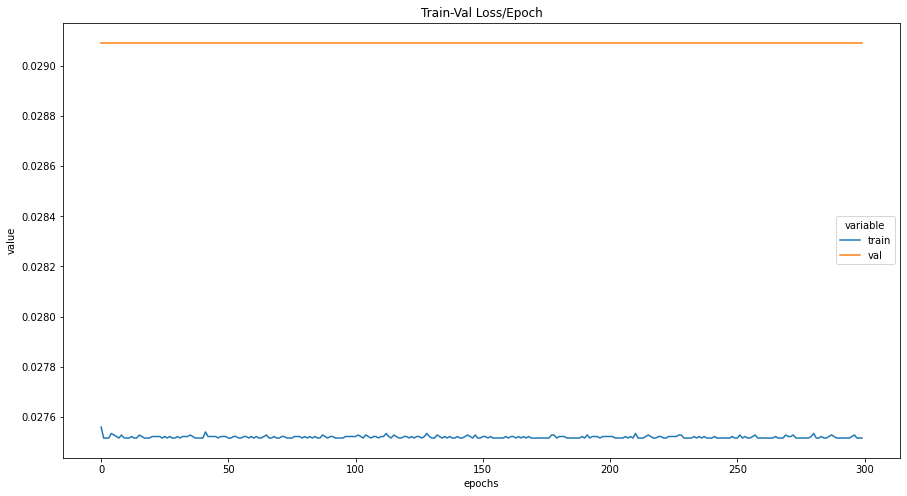

In [15]:
# Visualize loss
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.show()

In [16]:
# Test model
y_pred_list = []

# Reload the model that was the best
model.load_state_dict(torch.load(best_model_path))

with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader: # Originally test-loader
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print("Predicted and actual")
for y_pred, y_actual in zip(y_pred_list, y_test):
    print(y_pred, y_actual)
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("Mean Absolute Error :",mae)
print("R^2 :",r_square)

print("Values for avg as baseline would be")
y_pred_list = np.full(y_test.size, y_train.mean())
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("Mean Absolute Error :",mae)
print("R^2 :",r_square)

Predicted and actual
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


ValueError: Found input variables with inconsistent numbers of samples: [45, 24989]